## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [40]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
# Modelling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

#### Import the CSV Data as Pandas DataFrame

In [36]:
df = pd.read_csv('data/stud.csv')

#### Show Top 5 Records

In [38]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


#### Preparing X and Y variables

In [4]:
X = df.drop(columns=['math_score'],axis=1)

In [5]:
X.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [6]:
print("Categories in 'gender' variable:     ",end=" " )
print(df['gender'].unique())

print("Categories in 'race_ethnicity' variable:  ",end=" ")
print(df['race_ethnicity'].unique())

print("Categories in parental level of education' variable:",end=" " )
print(df['parental_level_of_education'].unique())

print("Categories in 'lunch' variable:     ",end=" " )
print(df['lunch'].unique())

print("Categories in 'test preparation course' variable:     ",end=" " )
print(df['test_preparation_course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race_ethnicity' variable:   ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:      ['standard' 'free/reduced']
Categories in 'test preparation course' variable:      ['none' 'completed']


In [7]:
y = df['math_score']

In [8]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math_score, Length: 1000, dtype: int64

In [9]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [10]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 7), (200, 7))

In [11]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [12]:
X_train.shape

(800, 19)

In [13]:
X_test.shape

(200, 19)

In [14]:
X_train

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.03079054,  0.43405338],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.9302895 ,  0.96470125],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.34544287,  1.1636942 ],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
        -0.52274728, -1.02522827],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
        -1.49143847, -1.02522827],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.48382733,  1.36268716]], shape=(800, 19))

In [15]:
type(X_train)

numpy.ndarray

In [16]:
import numpy as np

print("NaN:", np.isnan(X_train).sum())
print("Inf:", np.isinf(X_train).sum())

print("Max:", np.max(X_train))
print("Min:", np.min(X_train))

print("Zero variance columns:", np.where(np.var(X_train, axis=0) == 0))

NaN: 0
Inf: 0
Max: 2.1065573774175537
Min: -3.5458056743223123
Zero variance columns: (array([], dtype=int64),)


#### Create an Evaluate Function to give all metrics after model Training

In [17]:
# ============================================================================
# 1. Evaluation 함수
# ============================================================================
def evaluate_model(true, predicted):
    """
    모델 성능 평가 함수

    Parameters:
    - true: 실제값
    - predicted: 예측값

    Returns:
    - mae, rmse, r2_square
    """
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [18]:
# ============================================================================
# 2. 하이퍼파라미터 탐색 설정
# ============================================================================
param_grids = {
    "Linear Regression": {},  # 튜닝할 파라미터 없음

    "Lasso": {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    },

    "Ridge": {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    },

    "K-Neighbors Regressor": {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },

    "Decision Tree": {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['squared_error', 'absolute_error']
    },

    "Random Forest Regressor": {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    },

    "XGBRegressor": {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },

    "CatBoosting Regressor": {
        'iterations': [100, 200],
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'l2_leaf_reg': [1, 3, 5]
    },

    "AdaBoost Regressor": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'loss': ['linear', 'square', 'exponential']
    }
}

In [19]:
# ============================================================================
# 3. 하이퍼파라미터 최적화 함수
# ============================================================================
def calculate_param_space_size(param_grid):
    """
    파라미터 그리드의 총 조합 수 계산
    """
    sizes = []
    for value in param_grid.values():
        if isinstance(value, list):
            sizes.append(len(value))

    total = 1
    for size in sizes:
        total *= size
    return total


def optimize_model(model, param_grid, X_train, y_train, model_name, cv=5, search_type='random'):
    """
    모델의 하이퍼파라미터 최적화

    Parameters:
    - model: 모델 객체
    - param_grid: 파라미터 그리드
    - X_train: 훈련 데이터
    - y_train: 훈련 레이블
    - model_name: 모델 이름
    - cv: 교차 검증 폴드 수
    - search_type: 'grid' 또는 'random'

    Returns:
    - best_model: 최적화된 모델
    - best_params: 최적 파라미터
    """

    if not param_grid:  # 튜닝할 파라미터가 없으면
        model.fit(X_train, y_train)
        print(f"{model_name}: 기본 파라미터 사용 (튜닝 파라미터 없음)")
        return model, {}

    try:
        if search_type == 'grid':
            print(f"{model_name}: GridSearchCV 진행 중...")
            search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                n_jobs=-1,
                verbose=0,
                scoring='r2'
            )
        else:  # random
            param_space_size = calculate_param_space_size(param_grid)
            n_iter = min(20, max(param_space_size // 3, 5))
            print(f"{model_name}: RandomizedSearchCV 진행 중...")
            search = RandomizedSearchCV(
                estimator=model,
                param_distributions=param_grid,
                n_iter=n_iter,
                cv=cv,
                n_jobs=-1,
                verbose=0,
                scoring='r2',
                random_state=42
            )

        search.fit(X_train, y_train)

        print(f"{model_name}: 최적 파라미터 찾음")
        print(f"\nBest CV Score (R²): {search.best_score_:.4f}")
        print(f"\nBest Params: {search.best_params_}\n")

        return search.best_estimator_, search.best_params_

    except Exception as e:
        print(f"{model_name} 최적화 실패: {str(e)}")
        print(f"\n기본 파라미터 사용\n")
        model.fit(X_train, y_train)
        return model, {}

In [20]:
# ============================================================================
# 4. 메인 훈련 및 평가 루프
# ============================================================================
def train_and_evaluate_all_models(X_train, y_train, X_test, y_test,
                                   search_type='random', cv=5):
    """
    모든 모델을 하이퍼파라미터 최적화 후 훈련 및 평가

    Parameters:
    - X_train, y_train: 훈련 데이터
    - X_test, y_test: 테스트 데이터
    - search_type: 'grid' 또는 'random'
    - cv: 교차 검증 폴드 수

    Returns:
    - results_df: 결과를 담은 DataFrame
    - best_model_info: 최고 성능 모델 정보
    """

    models = {
        "Linear Regression": LinearRegression(),
        "Lasso": Lasso(max_iter=1000),
        "Ridge": Ridge(),
        "K-Neighbors Regressor": KNeighborsRegressor(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest Regressor": RandomForestRegressor(random_state=42),
        "XGBRegressor": XGBRegressor(verbosity=0, n_jobs=-1, random_state=42),
        "CatBoosting Regressor": CatBoostRegressor(verbose=False, random_state=42),
        "AdaBoost Regressor": AdaBoostRegressor(random_state=42)
    }

    results = []
    best_r2 = -np.inf
    best_model_name = None

    print("="*80)
    print("모델 하이퍼파라미터 최적화 및 평가 시작")
    print("="*80 + "\n")

    for model_name, model in models.items():
        print(f"\n{'='*80}")
        print(f"{model_name} 처리 중...")
        print('='*80)

        # 1. 하이퍼파라미터 최적화
        param_grid = param_grids.get(model_name, {})
        best_model, best_params = optimize_model(
            model,
            param_grid,
            X_train,
            y_train,
            model_name,
            cv=cv,
            search_type=search_type
        )

        # 2. 예측
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        # 3. 평가
        train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred)
        test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)

        # 4. 결과 출력
        print(f"\n{model_name} - Training Set 성능:")
        print(f"   • MAE:  {train_mae:.4f}")
        print(f"   • RMSE: {train_rmse:.4f}")
        print(f"   • R²:   {train_r2:.4f}")

        print(f"\n{model_name} - Test Set 성능:")
        print(f"   • MAE:  {test_mae:.4f}")
        print(f"   • RMSE: {test_rmse:.4f}")
        print(f"   • R²:   {test_r2:.4f}")

        # 과적합 체크
        overfit_gap = train_r2 - test_r2
        if overfit_gap > 0.1:
            print(f"\n과적합 감지 (차이: {overfit_gap:.4f})")
        else:
            print(f"\n과적합 없음")

        # 5. 결과 저장
        results.append({
            'Model': model_name,
            'Best_Params': str(best_params),
            'Train_MAE': train_mae,
            'Train_RMSE': train_rmse,
            'Train_R2': train_r2,
            'Test_MAE': test_mae,
            'Test_RMSE': test_rmse,
            'Test_R2': test_r2,
            'Overfit_Gap': overfit_gap,
            'Best_Model_Object': best_model
        })

        # 최고 성능 모델 추적
        if test_r2 > best_r2:
            best_r2 = test_r2
            best_model_name = model_name

    # 결과를 DataFrame으로 변환
    results_df = pd.DataFrame(results)

    # 테스트 R² 기준으로 정렬
    results_df = results_df.sort_values('Test_R2', ascending=False).reset_index(drop=True)

    print("\n\n" + "="*80)
    print("최종 결과 요약 (Test R² 기준 정렬)")
    print("="*80)
    print(results_df[['Model', 'Test_MAE', 'Test_RMSE', 'Test_R2', 'Overfit_Gap']].to_string(index=False))

    print(f"\n최고 성능 모델: {best_model_name} (Test R²: {best_r2:.4f})")
    print("="*80 + "\n")

    best_model_info = {
        'model_name': best_model_name,
        'r2_score': best_r2,
        'model_object': results_df[results_df['Model'] == best_model_name]['Best_Model_Object'].values[0]
    }

    return results_df, best_model_info

In [21]:
# ============================================================================
# 5. 시각화 함수
# ============================================================================
def plot_advanced_comparison(results_df):
    """
    고급 모델 비교 시각화
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Test R² 순위
    ax1 = axes[0, 0]
    sorted_df = results_df.sort_values('Test_R2', ascending=True)
    ax1.barh(sorted_df['Model'], sorted_df['Test_R2'], color='skyblue')
    ax1.set_xlabel('Test R² Score')
    ax1.set_title('모델별 Test R² 성능')
    ax1.axvline(x=results_df['Test_R2'].max(), color='red', linestyle='--', label='Best')
    ax1.legend()

    # 2. Train vs Test R² (과적합 분석)
    ax2 = axes[0, 1]
    x = range(len(results_df))
    ax2.plot(x, results_df['Train_R2'], 'o-', label='Train R²', linewidth=2)
    ax2.plot(x, results_df['Test_R2'], 's-', label='Test R²', linewidth=2)
    ax2.set_xlabel('Model Index')
    ax2.set_ylabel('R² Score')
    ax2.set_title('과적합 분석 (Train vs Test)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(results_df['Model'], rotation=45, ha='right', fontsize=8)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. RMSE 비교
    ax3 = axes[1, 0]
    sorted_df_rmse = results_df.sort_values('Test_RMSE')
    ax3.barh(sorted_df_rmse['Model'], sorted_df_rmse['Test_RMSE'], color='lightcoral')
    ax3.set_xlabel('Test RMSE')
    ax3.set_title('모델별 Test RMSE')

    # 4. 과적합 정도 (Overfit Gap)
    ax4 = axes[1, 1]
    colors = ['green' if x < 0.1 else 'orange' if x < 0.2 else 'red'
              for x in results_df['Overfit_Gap']]
    ax4.barh(results_df['Model'], results_df['Overfit_Gap'], color=colors)
    ax4.axvline(x=0.1, color='orange', linestyle='--', label='Warning')
    ax4.set_xlabel('Overfit Gap (Train R² - Test R²)')
    ax4.set_title('과적합 정도\n(녹색: Good, 주황색: Warning, 빨강: Danger)')
    ax4.legend()

    plt.tight_layout()
    plt.show()

### Results

In [22]:
# ============================================================================
# 6. 실행
# ============================================================================

# 1. RandomizedSearchCV 사용 (권장 - 빠른 실행)
results_df, best_model_info = train_and_evaluate_all_models(
    X_train, y_train,
    X_test, y_test,
    search_type='random',  # 'grid' 또는 'random'
    cv=5
)

results_df

모델 하이퍼파라미터 최적화 및 평가 시작


Linear Regression 처리 중...
Linear Regression: 기본 파라미터 사용 (튜닝 파라미터 없음)

Linear Regression - Training Set 성능:
   • MAE:  4.2667
   • RMSE: 5.3231
   • R²:   0.8743

Linear Regression - Test Set 성능:
   • MAE:  4.2148
   • RMSE: 5.3940
   • R²:   0.8804

과적합 없음

Lasso 처리 중...
Lasso: RandomizedSearchCV 진행 중...
Lasso: 최적 파라미터 찾음

Best CV Score (R²): 0.8686

Best Params: {'alpha': 0.001}


Lasso - Training Set 성능:
   • MAE:  4.2667
   • RMSE: 5.3231
   • R²:   0.8743

Lasso - Test Set 성능:
   • MAE:  4.2137
   • RMSE: 5.3930
   • R²:   0.8805

과적합 없음

Ridge 처리 중...
Ridge: RandomizedSearchCV 진행 중...
Ridge: 최적 파라미터 찾음

Best CV Score (R²): 0.8686

Best Params: {'alpha': 1}


Ridge - Training Set 성능:
   • MAE:  4.2650
   • RMSE: 5.3233
   • R²:   0.8743

Ridge - Test Set 성능:
   • MAE:  4.2111
   • RMSE: 5.3904
   • R²:   0.8806

과적합 없음

K-Neighbors Regressor 처리 중...
K-Neighbors Regressor: RandomizedSearchCV 진행 중...
K-Neighbors Regressor: 최적 파라미터 찾음

Best CV Score (R²): 0.80

,Model,Best_Params,Train_MAE,Train_RMSE,Train_R2,Test_MAE,Test_RMSE,Test_R2,Overfit_Gap,Best_Model_Object
0,Ridge,{'alpha': 1},4.265005,5.323321,0.874304,4.211113,5.390418,0.880592,-0.006287,Ridge(alpha=1)
1,Lasso,{'alpha': 0.001},4.266698,5.323060,0.874317,4.213680,5.393004,0.880477,-0.006160,Lasso(alpha=0.001)
2,Linear Regression,{},4.266712,5.323051,0.874317,4.214763,5.393994,0.880433,-0.006116,LinearRegression()
3,XGBRegressor,"{'subsample': 0.9, 'n_estimators': 100, 'max_d...",3.785523,4.732529,0.900656,4.293232,5.581145,0.871992,0.028664,"XGBRegressor(base_score=None, booster=None, ca..."
4,CatBoosting Regressor,"{'learning_rate': 0.05, 'l2_leaf_reg': 3, 'ite...",4.034637,5.021107,0.888171,4.270313,5.599033,0.871170,0.017001,"CatBoostRegressor(depth=4, iterations=200, l2_..."
5,AdaBoost Regressor,"{'n_estimators': 50, 'loss': 'square', 'learni...",4.758075,5.796550,0.850963,4.755756,6.056528,0.849257,0.001706,"(DecisionTreeRegressor(max_depth=3, random_sta..."
6,Decision Tree,"{'min_samples_split': 5, 'min_samples_leaf': 2...",4.639612,5.717289,0.855011,4.931523,6.540001,0.824230,0.030781,"DecisionTreeRegressor(max_depth=5, min_samples..."
7,Random Forest Regressor,"{'n_estimators': 100, 'min_samples_split': 5, ...",3.298975,4.125345,0.924512,4.870241,6.540474,0.824204,0.100308,"(DecisionTreeRegressor(max_depth=10, max_featu..."
8,K-Neighbors Regressor,"{'weights': 'distance', 'n_neighbors': 13, 'me...",0.018750,0.279508,0.999653,5.557142,7.135446,0.790766,0.208887,"KNeighborsRegressor(metric='euclidean', n_neig..."


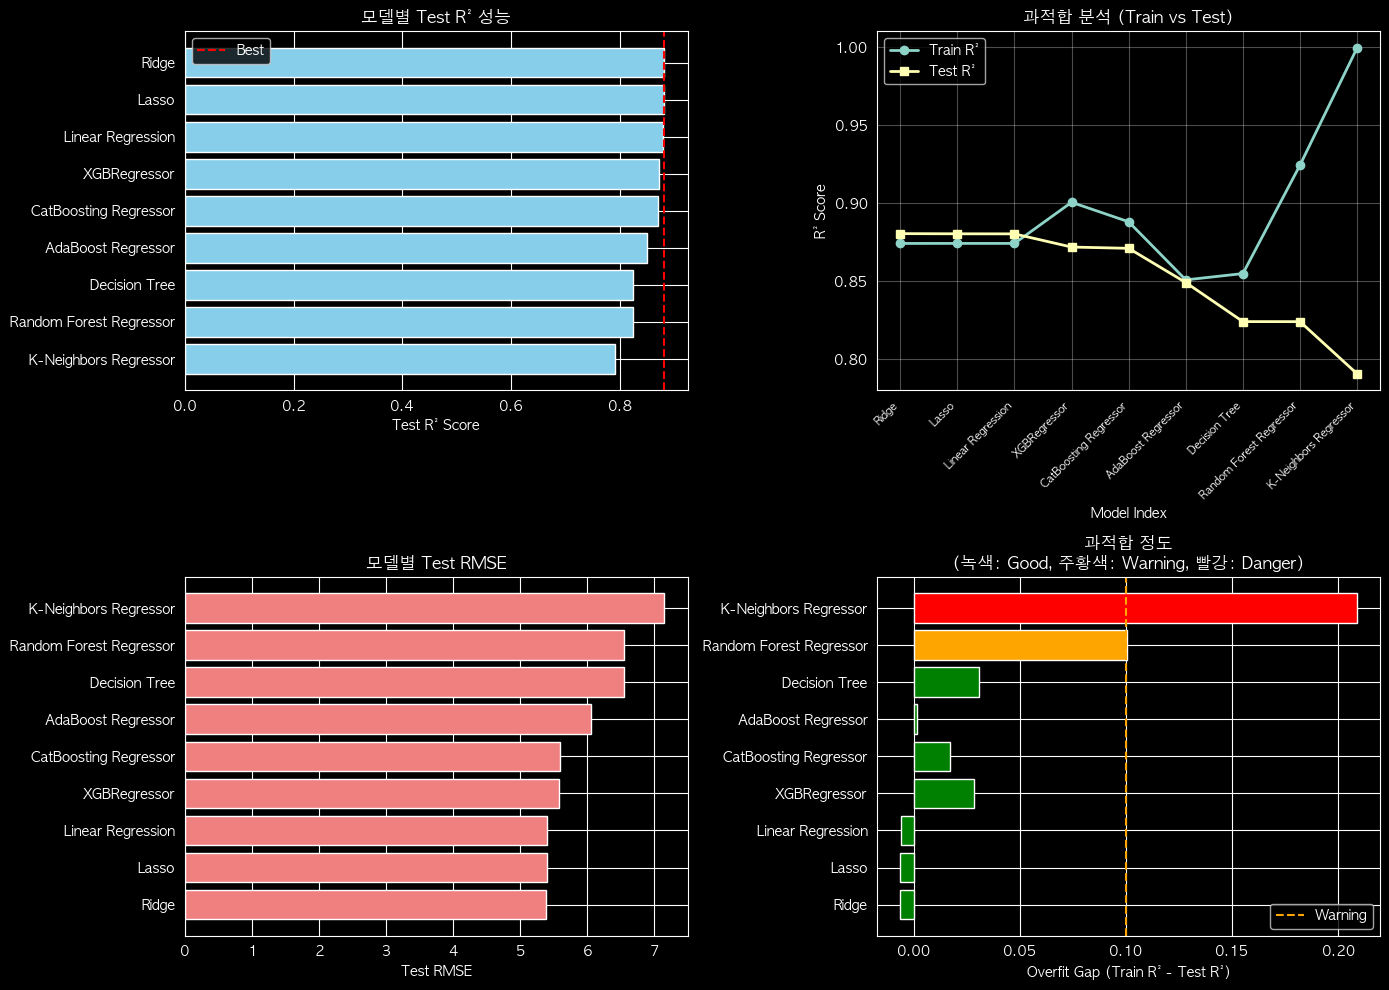

In [23]:
# 2. 시각화
plot_advanced_comparison(results_df)

In [24]:
# 3. 최고 성능 모델로 예측
best_model = best_model_info['model_object']
final_predictions = best_model.predict(X_test)
print(f"최고 성능 모델: {best_model_info['model_name']}")
print(f"Test R² Score: {best_model_info['r2_score']:.4f}")

최고 성능 모델: Ridge
Test R² Score: 0.8806


## Ridge Regression

In [25]:
ridge_model = Ridge(fit_intercept=True)
ridge_model = ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.06


## Plot y_pred and y_test

Text(0, 0.5, 'Predicted')

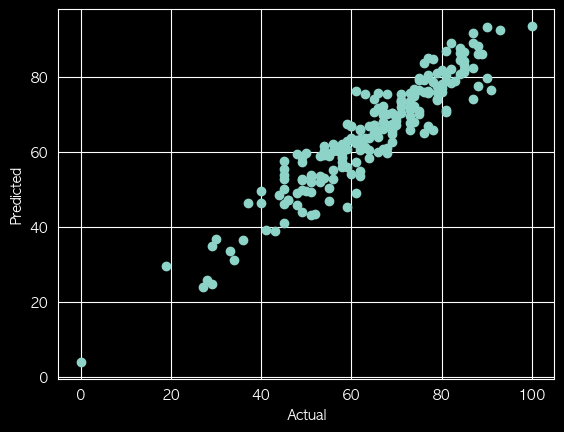

In [26]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='math_score'>

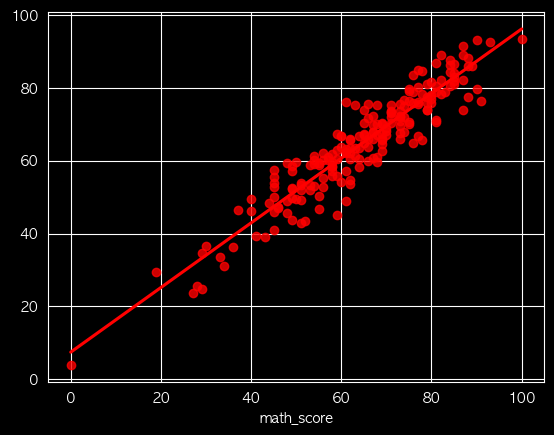

In [27]:
sns.regplot(x=y_test, y=y_pred, ci=None, color='red')

#### Difference between Actual and Predicted Values

In [166]:
pred_df = pd.DataFrame({'Actual Value': y_test, 'Predicted Value': y_pred, 'Difference': y_test - y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.39875,14.60125
737,53,58.84317,-5.84317
740,80,76.99204,3.00796
660,74,76.80620,-2.80620
411,84,87.61498,-3.61498
...,...,...,...
408,52,43.49177,8.50823
332,62,62.17010,-0.17010
208,74,67.91026,6.08974
613,65,67.06126,-2.06126


## Linear Regression

In [170]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.04


## Plot y_pred and y_test

Text(0, 0.5, 'Predicted')

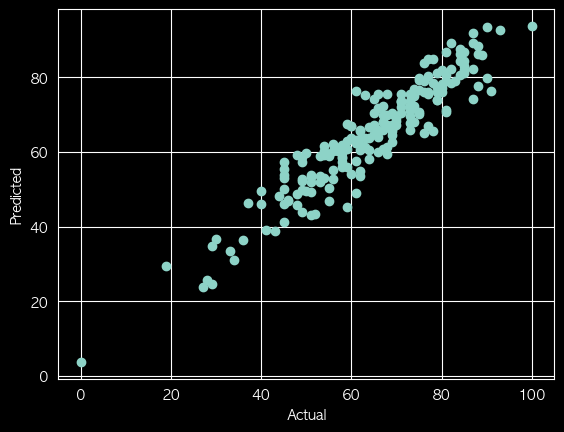

In [30]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='math_score'>

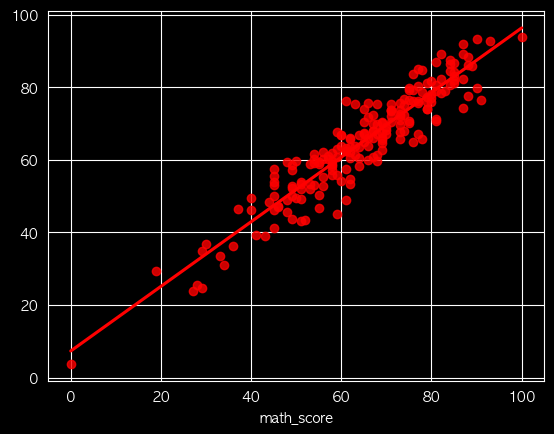

In [31]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')

#### Difference between Actual and Predicted Values

In [32]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.387970,14.612030
737,53,58.885970,-5.885970
740,80,76.990265,3.009735
660,74,76.851804,-2.851804
411,84,87.627378,-3.627378
...,...,...,...
408,52,43.409149,8.590851
332,62,62.152214,-0.152214
208,74,67.888395,6.111605
613,65,67.022287,-2.022287
